In [2]:

from transformers import CLIPImageProcessor, CLIPModel
from transformers import AutoProcessor
import torch
from torch.utils.data import ConcatDataset
import torchvision
import torchvision.transforms.v2 as transforms
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from collections import OrderedDict

In [3]:
dataset1 = torchvision.datasets.CIFAR10(root='../data/', train=False,
                                          download=True, transform=transforms.ToTensor())

dataset2 = torchvision.datasets.CIFAR10(root='../data/', train=True,
                                          download=True, transform=transforms.ToTensor())


images = np.append(dataset1.data, dataset2.data, axis=0)
labels = dataset1.targets + dataset2.targets

/Users/Mikolaj/miniconda3/envs/EDS4AI/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [4]:
slice_size = 10000

images_transposed = np.transpose(images, (0,3,1,2))
#images_slice = images_transposed[0:slice_size][:][:][:]

#for i in range(9):
    #np.append(images_slice, images_transposed[slice_size*i, slice_size*(i+1)][:][:][:], axis =0)

#print(images_slice.size)

print(images_transposed.shape)


(60000, 3, 32, 32)


In [10]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
image_processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")

image_embeddings = np.empty((0,512))

# number of images is too large to run clip on all of them so we have to do it in 1000 image batches
for i in range(2):
    images_slice = images_transposed[ (1000*i): (1000*(i+1)) ][:][:][:]

    clip_inputs = image_processor(images=images_slice, return_tensors="pt")
    clip_outputs = model.get_image_features(**clip_inputs).detach()

    image_embeddings = np.append(image_embeddings, clip_outputs, axis=0)

In [11]:
print(image_embeddings.shape)

#embeddings_list = image_embeddings[1:]
#image_embeddings = image_embeddings[0]

#for embds in embeddings_list:
    #image_embeddings = np.append(image_embeddings, 

#print(image_embeddings.shape)

(2000, 512)


In [12]:
print(type(image_embeddings))

<class 'numpy.ndarray'>


In [15]:
pca = PCA(n_components=50)
pca_results = pca.fit_transform(image_embeddings)

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(pca_results)

In [16]:
print(tsne_results.shape)

(2000, 2)


In [17]:
def calc_distance(coordinate_1, coordinate_2):
    return np.linalg.norm(coordinate_1 - coordinate_2)


def calc_distances(coords):
    num_coords = coords.shape[0]

    distance_lists = []
    for i in range(num_coords):
        coordinate = coords[i]
        distance_dict = {j : calc_distance(coordinate, coords[j]) for j in range(num_coords)}
        distance_lists.append(distance_dict)

    return distance_lists
    #return np.array(distance_lists)

def sort_distances(distances_list):
    from collections import OrderedDict

    m = len(distances_list)
    sorted_distances = []

    for i in range(m):
        unsorted_dict = distances_list[i]
        sorted_dict = OrderedDict(sorted(unsorted_dict.items(), key=lambda item: item[1], reverse=True))
        sorted_distances.append(sorted_dict)

    return sorted_distances

def generate_indexes(coords, sorted_distances, batch_size):
    m = coords.shape[0]
    batch = []

    #distances = calc_distances(coords)
    #sorted_distances = sort_distances(distances)

    indx = 0
    rng = np.random.default_rng()
    indx = rng.integers(0, m)
    batch.append(indx)
    prev_indx = indx

    for i in range(batch_size-1):
        distance_dict = sorted_distances[prev_indx]

        for indx, distance in distance_dict.items():
            if indx in batch:
                pass
            else :
                batch.append(indx)
                prev_indx = indx
                break

    return batch
    #yield batch

def generate_indexes_proportional(coords, sorted_distances, batch_size):
    m = coords.shape[0]
    batch = []

    rng = np.random.default_rng()
    indx = rng.integers(0, m)
    batch.append(indx)
    prev_indx = indx

    for i in range(batch_size-1):
        distance_dict = sorted_distances[prev_indx]

        #remove previously used batch indexes from consider
        for indx in batch:
            if indx in distance_dict.keys():
                distance_dict.pop(indx)

    
        indxs = list(distance_dict.keys())
        distances = list(distance_dict.values())

        probabilities = np.array(distances) / sum(distances)

        indx = np.random.choice(indxs, p=probabilities)

        batch.append(indx)
        prev_indx = indx


    return batch
    #yield batch


In [18]:
distances = calc_distances(tsne_results)
sorted_distances = sort_distances(distances)

In [51]:
batch_indexes = generate_indexes_proportional(tsne_results, sorted_distances, 100)

In [52]:
column_vals = ['x1', 'x2']

df = pd.DataFrame(data = tsne_results, columns=column_vals)

m = tsne_results.shape[0]
chosen = ['not chosen' for x in range(m)]
for indx in batch_indexes:
    chosen[indx] = 'batch element'

df['label'] = chosen

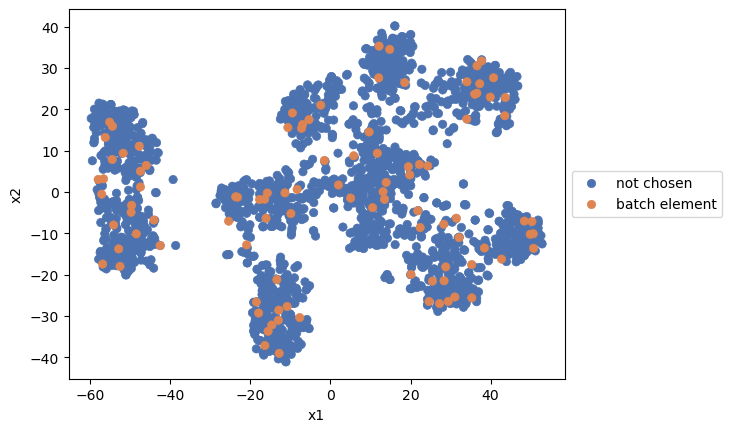

In [53]:
hue_order = ['not chosen', 'batch element']
df_sorted = df.sort_values('label', key=np.vectorize(hue_order.index))

plot = sns.scatterplot(x='x1', y='x2', data=df_sorted, hue='label', ec=None, palette="deep")
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [95]:
gen = np.random.default_rng()
indx = gen.integers(0, m)
print(indx)

457


In [119]:
import random

# Example dictionary
my_dict = {'apple': 1.5, 'pear': 3, 'orange': 6}

# Use random.choices with the dictionary keys and weights (values from the dictionary)
chosen_fruit = random.choices(list(my_dict.keys()), weights=list(my_dict.values()), k=1)[0]

print(chosen_fruit)


orange


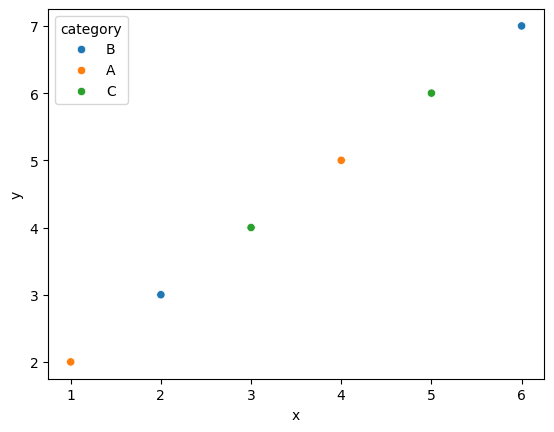

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'x': [1, 2, 3, 4, 5, 6],
    'y': [2, 3, 4, 5, 6, 7],
    'category': ['A', 'B', 'C', 'A', 'C', 'B']
}

# Create a DataFrame
df = pd.DataFrame(data)

# Scatterplot with hue_order parameter
sns.scatterplot(data=df, x='x', y='y', hue='category', hue_order=['B', 'A', 'C'])

# Display the plot
plt.show()
